# Refine ChartQA QA Pairs for RAG

In [1]:
from settings import *

## Load ChartQA

In [2]:
from chartqa_dataset import load_chartqa_dataset
    
dset = load_chartqa_dataset()
dset

DatasetDict({
    train: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine', 'image_id'],
        num_rows: 28299
    })
    val: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine', 'image_id'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine', 'image_id'],
        num_rows: 2500
    })
})

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine', 'image_id'],
    num_rows: 28299
})

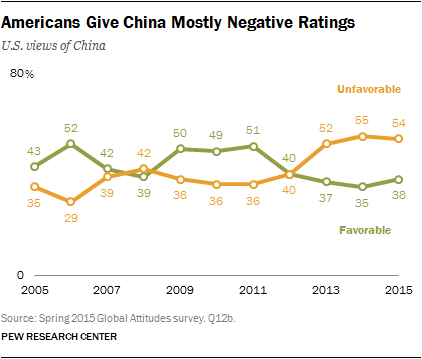

Is the value of Favorable 38 in 2015? -- ['Yes']




In [3]:
def show_sample(row: dict):
    display(row["image"])
    print(f'{row["query"]} -- {row["label"]}')  
    print("\n")

display(dset["train"])
for i in range(1):
    show_sample(dset["train"][i])

## Generate and Store Refined QAs

In [4]:
import subprocess
import sys

def run_isolated(vlm_name: str = "qwen25_vl_7b_instruct",  
                 split: str = "val", 
                 max_samples: int = 100,
                 force_update: bool = False):

    command = [
        sys.executable, "-m", "refine_chartqa", 
        "--vlm_name", vlm_name,
        "--split", split,
        "--max_samples", str(max_samples),
    ]
    if force_update:
        command.append("--force_update")
        
    subprocess.run(command)

run_isolated(vlm_name="qwen25_vl_7b_instruct", force_update=False)

Loading checkpoint shards: 100%|██████████| 5/5 [00:39<00:00,  7.93s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 2842.57 examples/s]


Saving the refined chartqa dataset to /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_7b_instruct


In [5]:
run_isolated(vlm_name="qwen25_vl_32b_instruct", force_update=False)

Loading checkpoint shards: 100%|██████████| 18/18 [00:32<00:00,  1.80s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 2217.79 examples/s]


Saving the refined chartqa dataset to /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_32b_instruct


In [6]:
run_isolated(vlm_name="qwen25_vl_72b_instruct_awq", force_update=False)

`torch.bfloat16` is not supported for AWQ CUDA kernels yet. Casting to `torch.float16`.
/fs01/home/ws_sabbasi/projects/chartqa_visual_rag/.myvenv/lib/python3.10/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)
Loading checkpoint shards: 100%|██████████| 11/11 [04:47<00:00, 26.18s/it]
Using a slow image

Saving the refined chartqa dataset to /projects/multimodal_bootcamp/multimodal-td-2/shared/refined_chartqa/val-100_qwen25_vl_72b_instruct_awq


Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 1406.38 examples/s]


## Visualize Sample Results

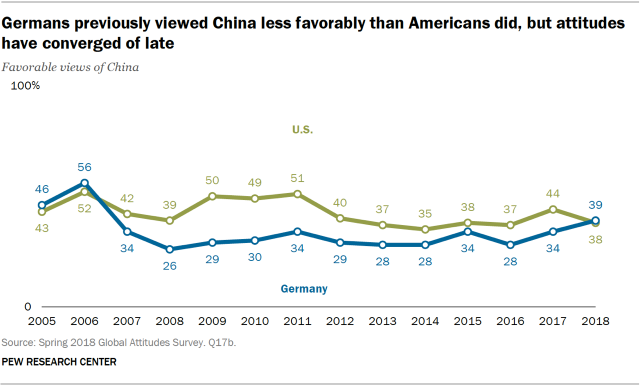

> Original QA: What's the color of graph with 56 as the highest value? -- ['Blue']
- "qwen25_vl_7b_instruct" QA: Which line on the graph reaches its peak at 56? -- ['Blue']
- "qwen25_vl_32b_instruct" QA: In a survey comparing favorable views of China between Germany and the U.S., which country had the highest percentage of favorable views in 2006, and what was the corresponding percentage? -- ['U.S.', '56%']
- "qwen25_vl_72b_instruct_awq" QA: In a line chart comparing favorable views of China between the U.S. and Germany from 2005 to 2018, which color represents the data series for the U.S. that peaks at 56? -- ['Blue']



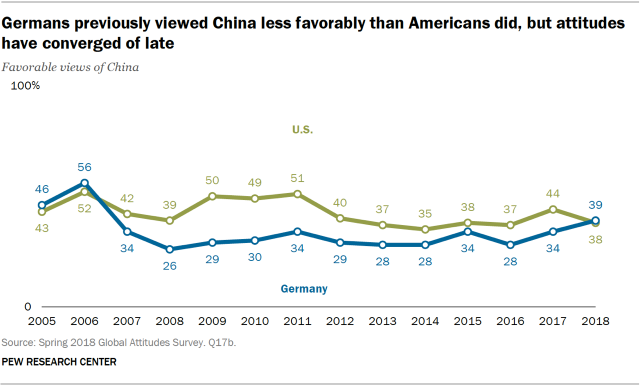

> Original QA: In which year the difference between blue and green graph 1? -- ['2018']
- "qwen25_vl_7b_instruct" QA: In what year did the difference between favorable views of China in Germany and the U.S. reach its highest point? -- ['2006']
- "qwen25_vl_32b_instruct" QA: In which year did the difference between the favorable views of China among Americans and Germans reach its smallest value according to the data shown? -- ['2018']
- "qwen25_vl_72b_instruct_awq" QA: In which year did the difference in favorable views of China between Germany and the U.S. become 1 percentage point according to the provided data? -- ['2018']



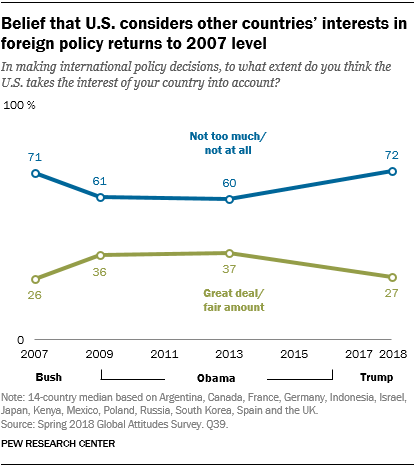

> Original QA: What does the blue line represent? -- ['Not too much/not at all']
- "qwen25_vl_7b_instruct" QA: What percentage of respondents believe the U.S. does not consider their country's interests in foreign policy decisions? -- ['72%']
- "qwen25_vl_32b_instruct" QA: In a survey measuring public perception of how much the U.S. considers other countries' interests in its foreign policy decisions, what category does the blue line represent over time? -- ['Not too much/not at all']
- "qwen25_vl_72b_instruct_awq" QA: In a chart showing the belief that the U.S. considers other countries' interests in foreign policy decisions, what does the blue line represent? -- ['Not too much/not at all']



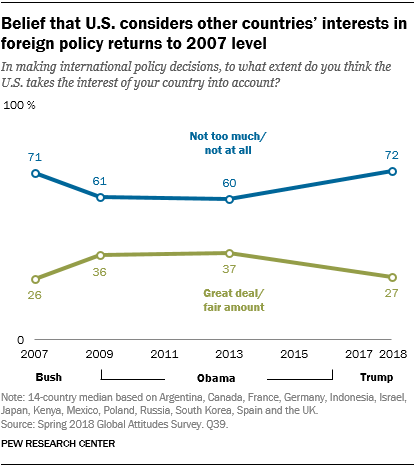

> Original QA: What is the max value of blue line? -- ['0.72']
- "qwen25_vl_7b_instruct" QA: What is the highest percentage shown on the blue line in the chart? -- ['0.72']
- "qwen25_vl_32b_instruct" QA: In a survey conducted across multiple countries, what was the highest percentage reported for the belief that the U.S. takes other countries' interests into account 'not too much/not at all' when making international policy decisions? -- ['0.72']
- "qwen25_vl_72b_instruct_awq" QA: Based on the data presented in a chart tracking the belief that the U.S. considers other countries' interests in foreign policy decisions, what is the highest percentage recorded for the belief that the U.S. does not consider their interests too much or at all? -- ['0.72']



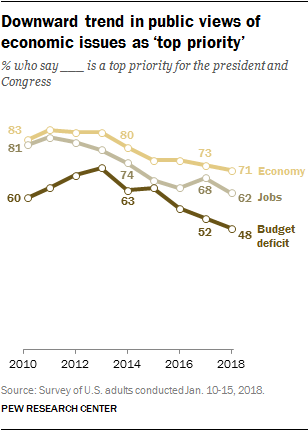

> Original QA: What's the percentage of respondents who say Job is a top priority for the president and Congress in 2016? -- ['68']
- "qwen25_vl_7b_instruct" QA: In 2016, what percentage of respondents said that jobs were a top priority for the president and Congress? -- ['68']
- "qwen25_vl_32b_instruct" QA: According to a survey conducted by the Pew Research Center, what percentage of U.S. adults indicated that 'Jobs' was a top priority for the president and Congress in 2016? -- ['68']
- "qwen25_vl_72b_instruct_awq" QA: According to a survey conducted by the Pew Research Center from 2010 to 2018, what percentage of U.S. adults said that 'Jobs' was a top priority for the president and Congress in 2016? -- ['68']



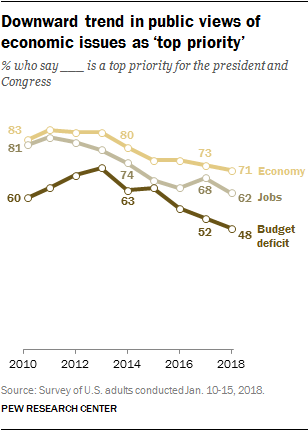

> Original QA: Which line has the lowest value of 71%? -- ['Economy']
- "qwen25_vl_7b_instruct" QA: In which category did 71% of respondents say was a top priority for the president and Congress? -- ['Economy']
- "qwen25_vl_32b_instruct" QA: In a survey conducted by Pew Research Center, which economic issue was rated as a top priority for the president and Congress at 71% in 2018? -- ['Economy']
- "qwen25_vl_72b_instruct_awq" QA: In a survey conducted from 2010 to 2018 on public views of economic issues as 'top priority', which issue had a value of 71% in 2018? -- ['Economy']



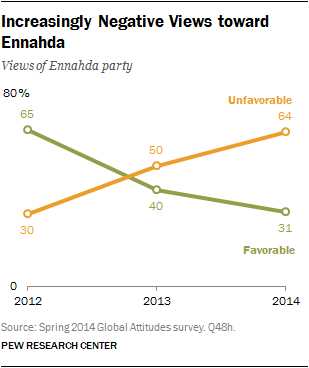

> Original QA: What is the unfavourable value in 2014? -- ['64']
- "qwen25_vl_7b_instruct" QA: What percentage of people viewed Ennahda unfavorably in 2014? -- ['64']
- "qwen25_vl_32b_instruct" QA: According to a survey conducted by Pew Research Center, what percentage of respondents had unfavorable views of the Ennahda party in 2014? -- ['64']
- "qwen25_vl_72b_instruct_awq" QA: According to a survey tracking views on the Ennahda party over several years, what was the percentage of unfavorable views reported in 2014? -- ['64']



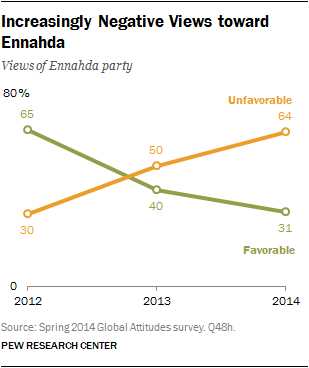

> Original QA: What is the median value of favourable line in the graph? -- ['40']
- "qwen25_vl_7b_instruct" QA: What is the median value of the favorable line in the graph? -- ['40']
- "qwen25_vl_32b_instruct" QA: In a survey tracking public opinion over time, two trends were observed: one for favorable views and another for unfavorable views of a political party. The favorable trend started at 65% in 2012, decreased to 40% in 2013, and further declined to 31% in 2014. What is the median value of the favorable trend across these three years? -- ['40']
- "qwen25_vl_72b_instruct_awq" QA: In a survey tracking views toward the Ennahda party over three years (2012, 2013, and 2014), what is the median percentage of respondents who held favorable views? -- ['40']



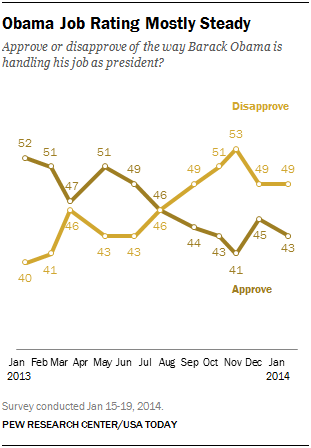

> Original QA: Which answer response has the highest value on this graph? -- ['Disapprove']
- "qwen25_vl_7b_instruct" QA: What was the highest percentage of respondents who disapproved of Barack Obama's job performance as president? -- ['53%']
- "qwen25_vl_32b_instruct" QA: In a survey conducted by Pew Research Center/USA Today in January 2014, which response category—'Approve' or 'Disapprove'—had the highest percentage when asked about public opinion regarding Barack Obama's job performance as president? -- ['Disapprove']
- "qwen25_vl_72b_instruct_awq" QA: In the line chart showing approval and disapproval ratings for Barack Obama's job performance as president over time, which response category reaches the highest value? -- ['Disapprove']



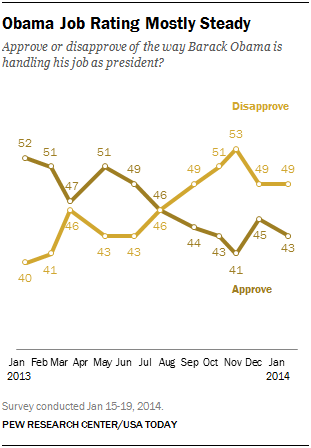

> Original QA: How many data points on the disapprove line are above 50? -- ['2']
- "qwen25_vl_7b_instruct" QA: How many times did the percentage of people who disapproved of Barack Obama's job performance exceed 50% during the period shown in the chart? -- ['2']
- "qwen25_vl_32b_instruct" QA: In a survey tracking public approval or disapproval of a political figure's job performance over several months, how many data points on the 'disapprove' trend line exceed 50%? -- ['2']
- "qwen25_vl_72b_instruct_awq" QA: In the survey tracking approval ratings for Barack Obama's job performance as president, how many data points on the 'Disapprove' line exceed 50%? -- ['2']



In [7]:
from datasets import Dataset

refined_dsets = {}
for vlm_name in ["qwen25_vl_7b_instruct", "qwen25_vl_32b_instruct", "qwen25_vl_72b_instruct_awq"]:
    refined_path = f"{TEAM_ROOT_DIR}/refined_chartqa/val-100_{vlm_name}"
    if os.path.exists(refined_path):
        refined_dsets[vlm_name] = Dataset.load_from_disk(refined_path)

for i in range(10):
    for vlm_i, (vlm_name, refined_dset) in enumerate(refined_dsets.items()):
        row = refined_dset[i]
        if vlm_i == 0:
            display(row["image"])
            print(f'> Original QA: {row["query"]} -- {row["label"]}')
        print(f'- "{vlm_name}" QA: {row[f"refined_query"]} -- {row[f"refined_label"]}')
    print(120 * "=" + "\n")

    